# Clustering Recipes by Ingredients 

## Loading Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 

## Importing the data

In [2]:
recipes_df=pd.read_csv('recipes_df.csv')
recipes_df.set_index('id', inplace=True)
reviews_df=pd.read_csv('reviews_df.csv')
reviews_df.set_index('recipe_id', inplace=True)
tags_matrix=pd.read_csv('tags_matrix.csv')
tags_matrix.set_index('id', inplace=True)
ingredients_matrix=pd.read_csv('ingredients_matrix.csv')
ingredients_matrix.set_index('id', inplace=True)

Let's use the ingredients matrix to cluster recipes into groups and see if there are any patterns. We will use K-Means Clustering and will pick the number of clusters K using the Elbow method.

## Choosing K: The Elbow Sum-of-Squares Method

First, we need to create the matrix with only 0-s and 1-s from the ingredients_matrix

In [3]:
x_cols=ingredients_matrix.values

Apply the [`KMeans`] clustering method from scikit-learn to this matrix:

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans()
clusters_pred = kmeans.fit_transform(x_cols)

Now let's construct an Elbow plot showing  sum-of-squares  for each  𝐾  and pick  𝐾  using this plot. For simplicity we will test 2≤𝐾≤20

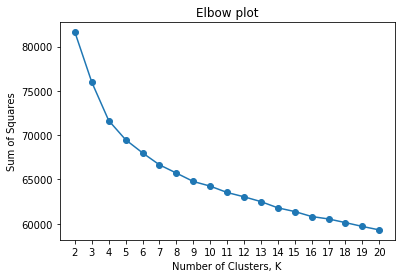

In [5]:
ks = range(2,21)
ss = []

for k in ks:
    model=KMeans(n_clusters=k,random_state=10)
    model.fit(x_cols)
    ss.append(model.inertia_)

plt.plot(ks, ss, '-o')
plt.title('Elbow plot')
plt.xlabel('Number of Clusters, K')
plt.ylabel('Sum of Squares')
plt.xticks(ks)
plt.show()

From the chart above we can say that the best K is somewhwere between 3 and 7. Let's try K=7

We make a bar chart showing the number of points in each cluster for k-means under the best K:

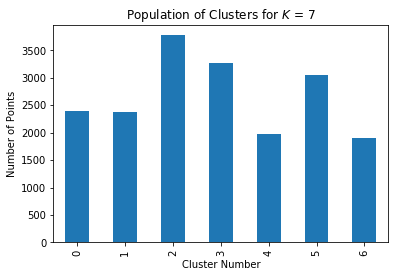

In [6]:
cluster_pred = KMeans(n_clusters=7, random_state=10).fit_predict(x_cols)

cluster_population = pd.Series(cluster_pred).value_counts().sort_index()
cluster_population

_ = cluster_population.plot(kind='bar')
_ = plt.ylabel('Number of Points')
_ = plt.xlabel('Cluster Number')
_ = plt.title('Population of Clusters for $K$ = 7')

## Choosing K: The Silhouette Method

Let's use another method for choosing K to strengthen our conclusion from the Elbow method. The Silhouette method measures how well each datapoint  𝑥𝑖  "fits" its assigned cluster and also how poorly it fits into other clusters. This is a different way of looking at the same objective. We will check K range between 4 and 7 and choose K with the silhouette score closest to 1.

For n_clusters = 3 The average silhouette_score is : 0.19172585856463387
For n_clusters = 4 The average silhouette_score is : 0.18957449729577003
For n_clusters = 5 The average silhouette_score is : 0.18111405590654364
For n_clusters = 6 The average silhouette_score is : 0.16267324366196434
For n_clusters = 7 The average silhouette_score is : 0.1632525460602517


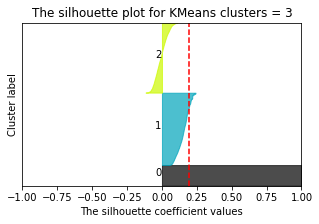

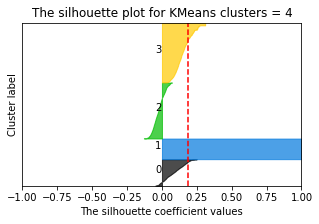

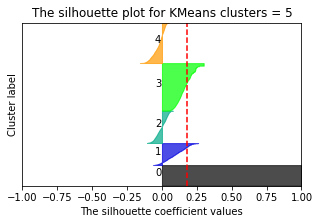

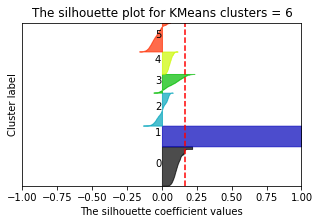

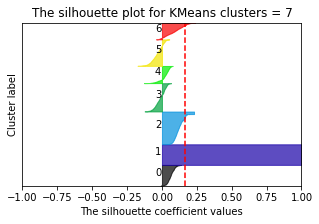

In [37]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = range(3,8)
silhouette_avgscores = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    _ = fig.set_size_inches(5,3)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    _ = ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    _ = ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgscores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        _=ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    _ = ax1.set_title("The silhouette plot for KMeans clusters = %d" % n_clusters)
    _ = ax1.set_xlabel("The silhouette coefficient values")
    _ = ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    _ = ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    _ = ax1.set_yticks([])  # Clear the yaxis labels / ticks
    _ = ax1.set_xticks([-1, 1], minor=True)

plt.show()

The silhoette score is best for K=3, and even then the score < 0.25 indicates that no substantial structure has been found. Going forward we will use K=3 as the best K.

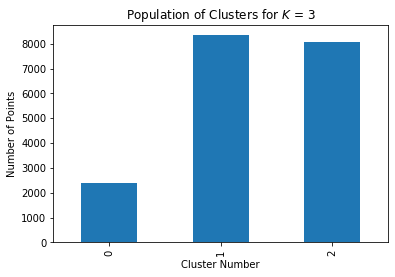

In [41]:
cluster_pred = KMeans(n_clusters=3, random_state=10).fit_predict(x_cols)

cluster_population = pd.Series(cluster_pred).value_counts().sort_index()
cluster_population

_ = cluster_population.plot(kind='bar')
_ = plt.ylabel('Number of Points')
_ = plt.xlabel('Cluster Number')
_ = plt.title('Population of Clusters for $K$ = 3')

## Visualizing Clusters using PCA

To visualize clusters, we need to reduce the dimensionality of our data from 149 ingredients (dimensions) to something lower.

In [7]:
ingredients_matrix.shape

(18762, 149)

We will use PCA to transform our multi-dimensional dataset into a 2 dimensional dataset.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_cols)
print(pca_features.shape)

(18762, 2)


Now let's create a data frame with the following fields: 
- recipe_id
- cluster id the customer belongs to
- the two PCA components (`x` and `y`)

In [38]:
# Adding customer name to dataframe
df_pca = pd.DataFrame(np.array(ingredients_matrix.index))

# Adding cluster id the customer belongs to
# (we use 7 clusters model)
clusterer = KMeans(n_clusters=3, random_state=10)
df_pca['cluster_label'] = pd.DataFrame(clusterer.fit_predict(x_cols)) 

# Adding the two PCA components (we use pca_features variable built earlier in the code)
df_pca['x'] = pd.DataFrame(pca_features[:,0])
df_pca['y'] = pd.DataFrame(pca_features[:,1])
df_pca.columns = ['recipe_id', 'cluster_id', 'x', 'y']
df_pca

,recipe_id,cluster_id,x,y
0,63986,2,-1.600178,-0.321058
1,43026,1,-1.687400,-0.161502
2,23933,1,-1.917816,0.021887
3,54100,2,-1.501276,-0.434043
4,67664,1,-1.759806,0.195130
...,...,...,...,...
18757,71450,1,-0.963012,1.564500
18758,96811,2,-1.524200,-0.534562
18759,116488,2,-0.539331,-1.422448
18760,208429,2,-1.274195,-0.719413


We plot a scatterplot of the `x` vs `y` columns and color-code points differently based on cluster ID

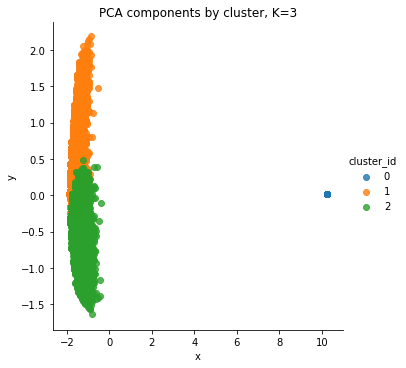

In [40]:
df_pca

_ = sns.lmplot(data=df_pca, x='x', y='y', hue='cluster_id',
           legend=True, legend_out=True, fit_reg=False)
#_ = plt.xlim(-2,2)
_ = plt.title('PCA components by cluster, K=3')

We can see that there is a clear break between the clusters, and the clusters do not overlap a lot.

What we've done is we've taken columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it x and then called the other y. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

Now let's add other recipe attributes to the clustered data: recipe_name and nutrition columns from recipes_df, all the ingredients from ingredients_matrix

In [47]:
recipes_df.head(2)

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,...,ingredients2,ingredients_check,nutrition2,Calories,Total Fat,Sugars,Sodium,Protein,Saturated Fat,Total Carbohydrate
id,,,,,,,,,,,,,,,,,,,,,
63986,chicken lickin good pork chops,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,"['lean pork chops', 'flour', 'salt', 'dry must...",...,"['lean pork chops', 'flour', 'salt', 'dry must...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['105.7', ' 8.0', ' 0.0', ' 26.0', ' 5.0', ' 4...",105.7,8.0,0.0,26.0,5.0,4.0,3.0
43026,chile rellenos,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"['drain green chiles', 'sprinkle cornstarch on...",a favorite from a local restaurant no longer i...,"['egg roll wrap', 'whole green chilies', 'chee...",...,"['egg roll wrap', 'whole green chilies', 'chee...","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","['94.0', ' 10.0', ' 0.0', ' 11.0', ' 11.0', ' ...",94.0,10.0,0.0,11.0,11.0,21.0,0.0


In [85]:
cluster_map = pd.DataFrame()
cluster_map['recipe_id'] = ingredients_matrix.index.values
cluster_map['cluster'] = clusterer.labels_
cluster_map.set_index('recipe_id', inplace=True)
df=cluster_map.merge(recipes_df[['name','Calories','Total Fat','Sugars','Sodium',
                                 'Protein','Saturated Fat','Total Carbohydrate']],
                     left_index=True, right_index=True)
df1=df.merge(ingredients_matrix,left_index=True, right_index=True)
df1.head(3)

,cluster,name,Calories,Total Fat,Sugars,Sodium,Protein,Saturated Fat,Total Carbohydrate,flour,...,broccoli,maple syrup,curry powder,ground coriander,turmeric,elbow macaroni,red wine,shallots,basil,sesame seeds
63986,2,chicken lickin good pork chops,105.7,8.0,0.0,26.0,5.0,4.0,3.0,1,...,0,0,0,0,0,0,0,0,0,0
43026,1,chile rellenos,94.0,10.0,0.0,11.0,11.0,21.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
23933,1,chinese candy,232.7,21.0,77.0,4.0,6.0,38.0,8.0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's inspect top 10 results in each cluster and see if we can label the clusters.

In [86]:
d={'recipe_name':[df1.name[df.cluster==i].head(10).values for i in range(0,3)],
   'top_10_ingredients': [df1.loc[:,'flour':][df1.cluster==i].sum().sort_values(ascending=False).head(10).index.values for i in range(0,3)],
  'Calories': [df1.Calories[df1.cluster==i].sum() for i in range(0,3)],
  'Sugars': [df1.Sugars[df1.cluster==i].sum() for i in range(0,3)],
   'Sodium': [df1.Sodium[df1.cluster==i].sum() for i in range(0,3)],
   'Protein': [df1.Protein[df1.cluster==i].sum() for i in range(0,3)],
   'Saturated Fat': [df1['Saturated Fat'][df1.cluster==i].sum() for i in range(0,3)],
   'Total Carbohydrate': [df1['Total Carbohydrate'][df1.cluster==i].sum() for i in range(0,3)]
  }
top10bycluster=pd.DataFrame(data=d)
top10bycluster

,recipe_name,top_10_ingredients,Calories,Sugars,Sodium,Protein,Saturated Fat,Total Carbohydrate
0,"[da best chicago style italian beef, i hate m...","[sesame seeds, thyme, ginger, tabasco sauce, f...",1285145.0,297944.0,74806.0,77959.0,119762.0,48137.0
1,"[chile rellenos, chinese candy, healthy for t...","[sugar, salt, butter, egg, flour, milk, water,...",3850483.8,911326.0,226026.0,224000.0,358662.0,148227.0
2,"[chicken lickin good pork chops, grilled ve...","[salt, garlic, onion, pepper, oil, butter, wat...",3384196.1,224985.0,322173.0,365498.0,329119.0,79829.0


In [97]:
top10bycluster.recipe_name[1]

array(['chile rellenos', 'chinese  candy',
       'healthy for them  yogurt popsicles', 'land of nod  cinnamon buns',
       'never weep  whipped cream', 'one bowl  perfect pound cake',
       'say what   banana sandwich', 'symphony  brownies',
       'the best  banana bread  or muffins',
       'the best  chocolate chip cheesecake ever'], dtype=object)

In [103]:
top10bycluster.top_10_ingredients[1]

array(['sugar', 'salt', 'butter', 'egg', 'flour', 'milk', 'water',
       'vanilla', 'baking powder', 'oil'], dtype=object)

Cluster 1 is the most obvious. The recipes have the highest sugar and carbohydrates content. By observing the recipe names it seems liek there are a lot of desserts and sweet things in this cluster.

In [102]:
top10bycluster.recipe_name[0]

array(['da best  chicago style italian beef',
       'i hate miracle whip  but i love this potato salad that s',
       'lupo s   chicken spiedies', 'starbucks  oat fudge bars',
       'subway  white chocolate macadamia nut cookies',
       'the real  black tie mousse cake by olive garden',
       '1 2 3 4 cake with caramel icing',
       '2 in 1   herbed chicken   leftover chicken salad',
       '2 alarm chili', '2 minute eggless microwave chocolate cake'],
      dtype=object)

In [99]:
top10bycluster.top_10_ingredients[0]

array(['sesame seeds', 'thyme', 'ginger', 'tabasco sauce',
       'fresh ground black pepper', 'rosemary', 'ground cloves',
       'egg white', 'vinegar', 'cocoa'], dtype=object)

Cluster 0 seems to have a combination of desserts, salads and meat dishes. It is the lowest on all nutritional values, so we may conclude that this is a "mid-day meal" cluster.

In [101]:
top10bycluster.recipe_name[2]

array(['chicken lickin  good  pork chops', 'grilled  venison burgers',
       'how i got my family to eat spinach  spinach casserole',
       'i stole the idea from mirj  sesame noodles',
       'immoral  sandwich filling  loose meat',
       'put down your fork   tuna and bean salad',
       'real  italian bolognese sauce',
       'stove top  bbq  beef or pork ribs',
       'ant  kelly s london broil marinade', 'go bears   party ryes'],
      dtype=object)

In [100]:
top10bycluster.top_10_ingredients[2]

array(['salt', 'garlic', 'onion', 'pepper', 'oil', 'butter', 'water',
       'parsley', 'sugar', 'parmesan cheese'], dtype=object)

Cluster 2 has a lot of recipes with meat and savory recipes, and has the hisghest protein and sodium content. We may conclude that this is the "Dinner" cluster.

To summarize, while no substantial cluster structure has been found, we can classify the 3 clusters as:
- Desserts/Baking Cluster
- Mid Day Meal Cluster
- Dinner Cluster